# In the name of God

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Question 10

#### defining masks

In [2]:
def generate_mask(i):
    return_value = np.zeros((3, 3))
    return_value[1, 1] = 1
    if i > 3:
        i += 1
    return_value[i // 3, i%3] = -1
    if i % 2 == 1:
        return_value = 2 * return_value
    return return_value

MASKS = [generate_mask(i) for i in range(8)]
for mask in MASKS:
    print('_______________')
    print(mask)

_______________
[[-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]
_______________
[[ 0. -2.  0.]
 [ 0.  2.  0.]
 [ 0.  0.  0.]]
_______________
[[ 0.  0. -1.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]
_______________
[[ 0.  0.  0.]
 [-2.  2.  0.]
 [ 0.  0.  0.]]
_______________
[[ 0.  0.  0.]
 [ 0.  2. -2.]
 [ 0.  0.  0.]]
_______________
[[ 0.  0.  0.]
 [ 0.  1.  0.]
 [-1.  0.  0.]]
_______________
[[ 0.  0.  0.]
 [ 0.  2.  0.]
 [ 0. -2.  0.]]
_______________
[[ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0. -1.]]


#### load a sample image

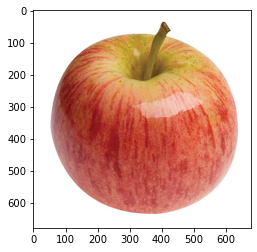

In [3]:
FILE_NAME = './apple.jpg'
img = cv2.imread(FILE_NAME)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

#### smooth this sample image

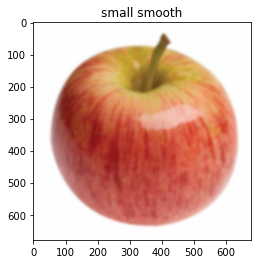

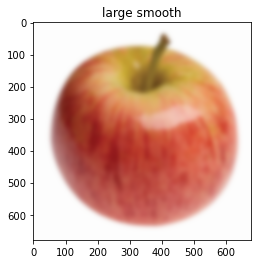

In [4]:
def gaussian_filter_LP(shape, std_dev, normalize_output = False):
    m, n = shape
    std_dev_x, std_dev_y = std_dev
    var_x = std_dev_x**2
    var_y = std_dev_y**2
    r = min(m, n) // 2
    x = np.arange(-m // 2, -m // 2 + m).reshape(-1, 1)
    y = np.arange(-n // 2, -n // 2 + n).reshape(1, -1)
    mask = np.exp(-(x**2 / (2 * var_x) + y**2 / (2 * var_y))) 
    if normalize_output:
        maks = mask / (2 * np.pi * std_dev_x * std_dev_y)
    return mask

def smooth_image(img, std_dev):
    m, n, c = img.shape
    return_value = np.zeros(img.shape).astype('uint8')
    for i in range(c):
        img_chn = img[:, :, i]
        img_chn_F = np.fft.fftshift(np.fft.fft2(img_chn))
        img_chn_F_masked = img_chn_F * gaussian_filter_LP((m, n), std_dev)
        return_value[:, :, i] = np.abs(np.fft.ifft2(np.fft.fftshift(img_chn_F_masked)))
    return return_value

img_small_smooth = smooth_image(img, (30, 30))
plt.title('small smooth')
plt.imshow(img_small_smooth)
img_large_smooth = smooth_image(img, (15, 15))
plt.figure()
plt.imshow(img_large_smooth)
plt.title('large smooth');

#### define important functions

In [5]:
def non_adaptive_unsharp_mask(img_in):
    mask = np.sum(MASKS, axis=0) / 16
    img_f = cv2.filter2D(img_in, -1, mask)
    return np.minimum(255, img_in.astype('uint16') + img_f).astype('uint8')

def adaptive_unsharp_mask(img_in, threshold):
    img_out = img_in.astype('uint16')
    for mask in MASKS:
        img_f = cv2.filter2D(img_in, -1, mask)
        img_f = img_f * (img_f > threshold).astype('uint8')
        img_out = img_out + img_f
    return np.minimum(255, img_out).astype('uint8')

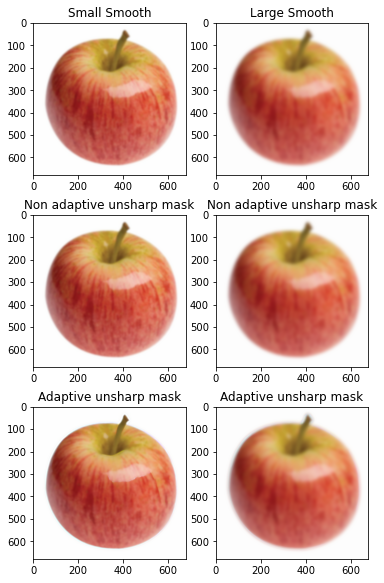

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(6, 10))

axes[0, 0].imshow(img_small_smooth)
axes[0, 0].set_title('Small Smooth')
axes[1, 0].imshow(non_adaptive_unsharp_mask(img_small_smooth))
axes[1, 0].set_title('Non adaptive unsharp mask')
axes[2, 0].imshow(adaptive_unsharp_mask(img_small_smooth, 10))
axes[2, 0].set_title('Adaptive unsharp mask')

axes[0, 1].imshow(img_large_smooth)
axes[0, 1].set_title('Large Smooth')
axes[1, 1].imshow(non_adaptive_unsharp_mask(img_large_smooth))
axes[1, 1].set_title('Non adaptive unsharp mask')
axes[2, 1].imshow(adaptive_unsharp_mask(img_large_smooth, 10))
axes[2, 1].set_title('Adaptive unsharp mask');

## the results of adaptive is better for small smooth

## Question 11

#### Load images

In [7]:
images = [cv2.imread(f'images/{i}.jpg') for i in range(6)]

#### merge same color channels into 3 images that has 6 channels 

In [8]:
get_all_channels = lambda imgs, chn: np.stack([img[:, :, chn] for img in imgs])

images_b = get_all_channels(images, 0)
images_g = get_all_channels(images, 1)
images_r = get_all_channels(images, 2)

#### define important functions

In [9]:
# use an linear transformation to make the range of image into[0, 255]
def fix_numbers(channel):
    channel = channel.astype('float128')
    min_v = np.min(channel)
    max_v = np.max(channel)
    channel = (channel - min_v) * 256 // (max_v - min_v)
    return channel.astype('uint8')

def pca_fit_transform(X, n_components):
    mean = np.average(X, axis=1).reshape(-1, 1)
    std_dev = np.std(X, axis=1).reshape(-1, 1)
    X = (X - mean) / std_dev
    covariance_matrix = np.cov(X.T)
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
    projection_matrix = (eigen_vectors.T[:][:n_components]).T
    return_value = X @ projection_matrix
    return_value = (return_value * std_dev) + mean
    return return_value
    
# input must be channel first - output will be channel first
def use_pca_for_image(img_inp, n_components):
    img_channel_first = img_inp # the input image is already channel first
    orig_shape = img_channel_first.shape # store old size
    img_as_row = img_channel_first.reshape(orig_shape[0], -1).transpose() # make image into (n_samples, n_features) style
    new_img_as_row = pca_fit_transform(img_as_row, n_components)
    new_img = new_img_as_row.transpose().reshape(n_components , orig_shape[1], orig_shape[2])
    for idx, channel in enumerate(new_img):
        new_img[idx] = fix_numbers(channel)
    
    return new_img.astype('uint8')#.transpose([1, 2, 0])

#### calculate best mapping of each channel using pca

In [10]:
chn_b = use_pca_for_image(images_b, 1)[0]
chn_g = use_pca_for_image(images_g, 1)[0]
chn_r = use_pca_for_image(images_r, 1)[0]

#### join all channels to create a color image

In [11]:
merged_channels = np.stack([chn_r, chn_g, chn_b], axis=-1)

#### displaying result

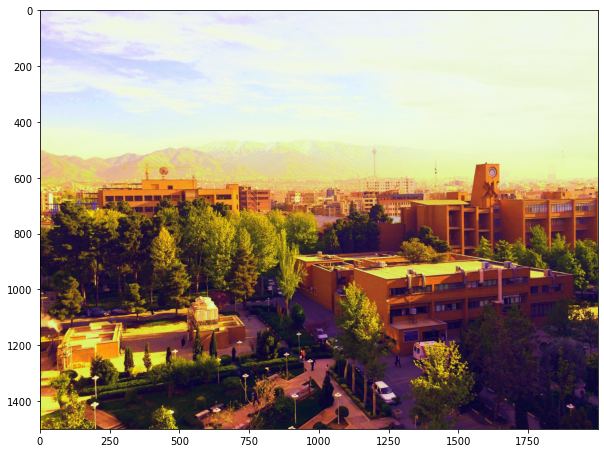

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(merged_channels)